In [3]:
# ============================================================================#
# PROJETO DE DEEP LEARNING PARA PROCESSAMENTO DE LINGUAGEM NATURAL
# Problema: Classificação de Tweets de Desastre
# ============================================================================#

# Bibliotecas básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

# Bibliotecas de ML tradicional (para comparação)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Dense, LSTM, Embedding, Dropout, Bidirectional,
                                     GlobalMaxPool1D, Conv1D, MaxPooling1D,
                                     GlobalAveragePooling1D, Input, concatenate)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2

# Otimização de hiperparâmetros
from sklearn.model_selection import GridSearchCV

# Para visualizações
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud

# Para processamento de texto
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Configurações
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
%matplotlib inline

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU disponível: {tf.config.list_physical_devices('GPU')}")

# Configurar GPU se disponível
if tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

TensorFlow version: 2.19.0
GPU disponível: []


=== ANÁLISE EXPLORATÓRIA DOS DADOS ===
Dimensões do conjunto de treino: (7613, 5)
Dimensões do conjunto de teste: (3263, 4)

Valores nulos no treino: 2594
Valores nulos no teste: 1131

Distribuição da variável target:
target
0    4342
1    3271
Name: count, dtype: int64
Proporção: 57.03% Não-Desastre, 42.97% Desastre


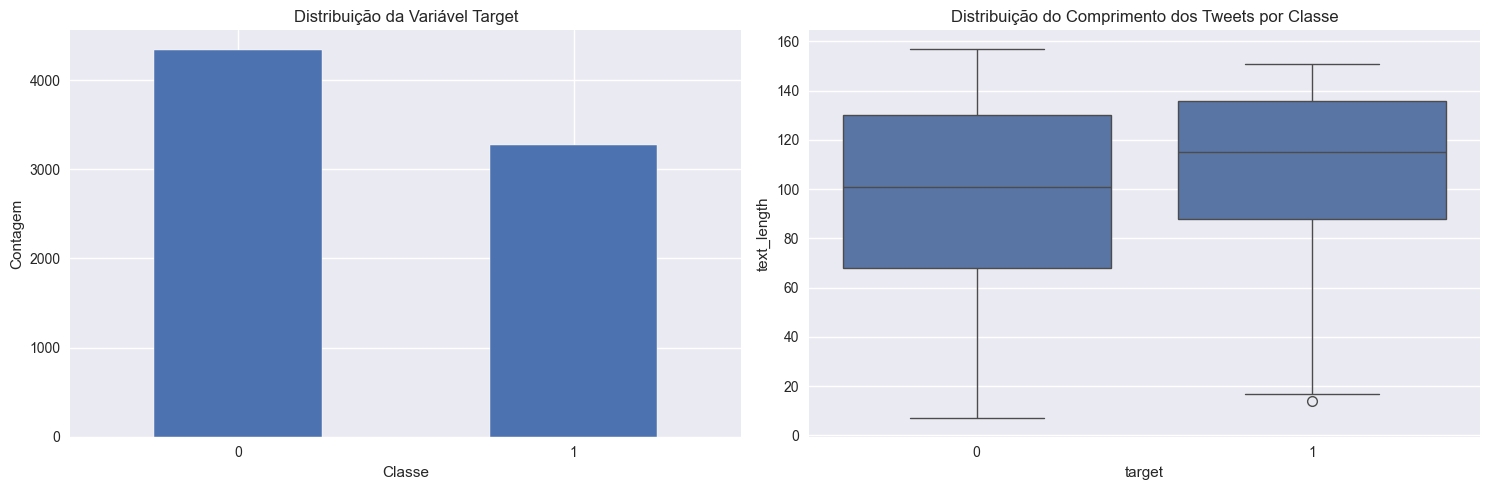

In [4]:
# ============================================================================
# 1. CARGA E EXPLORAÇÃO DOS DADOS
# ============================================================================

#Baixando recursos do NLTK necessários
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('punkt_tab', quiet=True)

#Carregando os dados
train_df = pd.read_csv(r"https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/train.csv")
test_df = pd.read_csv("https://raw.githubusercontent.com/Davisdenner/MVP---Machine-Learning-Analytics/main/test.csv")

print("=== ANÁLISE EXPLORATÓRIA DOS DADOS ===")
print(f"Dimensões do conjunto de treino: {train_df.shape}")
print(f"Dimensões do conjunto de teste: {test_df.shape}")

#Verificando valores nulos
print(f"\nValores nulos no treino: {train_df.isnull().sum().sum()}")
print(f"Valores nulos no teste: {test_df.isnull().sum().sum()}")

#Distribuição da variável target
print(f"\nDistribuição da variável target:")
target_dist = train_df['target'].value_counts()
print(target_dist)
print(f"Proporção: {target_dist[0] / len(train_df):.2%} Não-Desastre, {target_dist[1] / len(train_df):.2%} Desastre")

#Visualização da distribuição
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#Contagem
train_df['target'].value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Distribuição da Variável Target')
axes[0].set_xlabel('Classe')
axes[0].set_ylabel('Contagem')
axes[0].tick_params(axis='x', rotation=0)

#Comprimento dos tweets
train_df['text_length'] = train_df['text'].apply(len)
sns.boxplot(x='target', y='text_length', data=train_df, ax=axes[1])
axes[1].set_title('Distribuição do Comprimento dos Tweets por Classe')

plt.tight_layout()
plt.show()

In [5]:
# ============================================================================
# 2. PREPARAÇÃO E PRÉ-PROCESSAMENTO DOS DADOS
# ============================================================================

def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    #Convertendo para minúsculo
    text = text.lower()

    #Removendo URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #Removendo menções e hashtags (manter o conteúdo)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#', '', text)

    #Removendo caracteres especiais, manter espaços
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    #Removendo espaços extras
    text = re.sub(r'\s+', ' ', text).strip()

    #Tokenização
    tokens = word_tokenize(text)


    #Removendo stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    #Lematização
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)


#Aplicando pré-processamento
print("Aplicando pré-processamento nos dados...")
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

#Estatísticas do texto processado
print(f"Textos vazios após processamento (treino): {train_df['processed_text'].str.len().eq(0).sum()}")
print(f"Comprimento médio do texto processado: {train_df['processed_text'].str.len().mean():.1f}")

#Removendo textos vazios
train_df = train_df[train_df['processed_text'].str.len() > 0]
print(f"Dados restantes após limpeza: {len(train_df)}")

Aplicando pré-processamento nos dados...
Textos vazios após processamento (treino): 1
Comprimento médio do texto processado: 57.9
Dados restantes após limpeza: 7612


Tamanhos dos conjuntos:
Treino: 6089 (80.0%)
Validação: 1523 (20.0%)
Teste: 3263


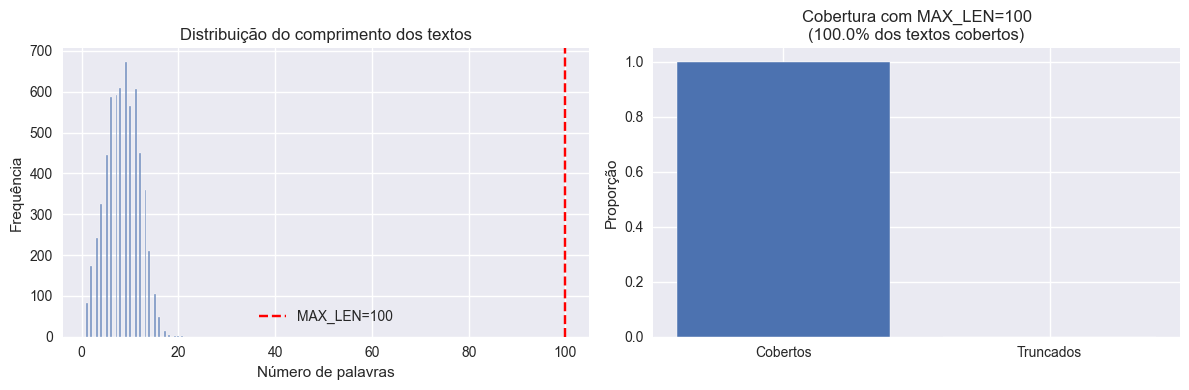


Após tokenização e padding:
Shape treino: (6089, 100)
Shape validação: (1523, 100)
Shape teste: (3263, 100)
Tamanho do vocabulário: 11482


In [6]:
# ============================================================================
# 3. SEPARAÇÃO TREINO/VALIDAÇÃO/TESTE E TOKENIZAÇÃO
# ============================================================================

# Preparar dados
X = train_df['processed_text']
y = train_df['target']

# Divisão estratificada treino/validação
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Tamanhos dos conjuntos:")
print(f"Treino: {len(X_train)} ({len(X_train) / len(X) * 100:.1f}%)")
print(f"Validação: {len(X_val)} ({len(X_val) / len(X) * 100:.1f}%)")
print(f"Teste: {len(test_df)}")

# Configurações para tokenização
MAX_FEATURES = 20000  # Tamanho do vocabulário
MAX_LEN = 100  # Comprimento máximo das sequências

# Análise do comprimento das sequências
text_lengths = X_train.apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, alpha=0.7)
plt.axvline(MAX_LEN, color='red', linestyle='--', label=f'MAX_LEN={MAX_LEN}')
plt.xlabel('Número de palavras')
plt.ylabel('Frequência')
plt.title('Distribuição do comprimento dos textos')
plt.legend()

plt.subplot(1, 2, 2)
coverage = (text_lengths <= MAX_LEN).mean()
plt.bar(['Cobertos', 'Truncados'], [coverage, 1 - coverage])
plt.title(f'Cobertura com MAX_LEN={MAX_LEN}\n({coverage:.1%} dos textos cobertos)')
plt.ylabel('Proporção')

plt.tight_layout()
plt.show()

# Tokenização
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Converter textos em sequências
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(test_df['processed_text'])

# Padding das sequências
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

print(f"\nApós tokenização e padding:")
print(f"Shape treino: {X_train_pad.shape}")
print(f"Shape validação: {X_val_pad.shape}")
print(f"Shape teste: {X_test_pad.shape}")
print(f"Tamanho do vocabulário: {len(tokenizer.word_index)}")

In [7]:
# ============================================================================
# 4. MODELOS DE DEEP LEARNING - ARQUITETURAS DIFERENTES
# ============================================================================

def create_simple_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    """Modelo LSTM simples"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_bidirectional_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    """Modelo LSTM Bidirecional"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
        GlobalMaxPool1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_cnn_model(vocab_size, embedding_dim=128):
    """Modelo CNN para texto"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    return model


def create_hybrid_model(vocab_size, embedding_dim=128):
    """Modelo híbrido CNN + LSTM"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        Conv1D(filters=64, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(50, dropout=0.5, recurrent_dropout=0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model


# Criar todos os modelos
models = {
    'LSTM_Simples': create_simple_lstm(MAX_FEATURES),
    'LSTM_Bidirecional': create_bidirectional_lstm(MAX_FEATURES),
    'CNN': create_cnn_model(MAX_FEATURES),
    'CNN_LSTM_Híbrido': create_hybrid_model(MAX_FEATURES)
}

# Mostrar arquiteturas
for name, model in models.items():
    print(f"\n=== ARQUITETURA {name} ===")
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.build(input_shape=(None, MAX_LEN))  # Construir o modelo
    print(f"Parâmetros treináveis: {model.count_params():,}")


=== ARQUITETURA LSTM_Simples ===
Parâmetros treináveis: 2,611,521

=== ARQUITETURA LSTM_Bidirecional ===
Parâmetros treináveis: 2,669,185

=== ARQUITETURA CNN ===
Parâmetros treináveis: 2,640,193

=== ARQUITETURA CNN_LSTM_Híbrido ===
Parâmetros treináveis: 2,610,969


In [8]:
# ============================================================================
# 5. TREINAMENTO DO MODELO LSTM SIMPLES
# ============================================================================

# Criar apenas o modelo LSTM simples
def create_simple_lstm(vocab_size, embedding_dim=128, lstm_units=64):
    """Modelo LSTM simples"""
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=MAX_LEN),
        LSTM(lstm_units, dropout=0.5, recurrent_dropout=0.5),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

# Criar o modelo
model = create_simple_lstm(MAX_FEATURES)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print("=== ARQUITETURA LSTM SIMPLES ===")
print(f"Parâmetros treináveis: {model.count_params():,}")
model.summary()

# Callbacks para otimização do treinamento
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=0.0001, verbose=1)
]

print("\n=== INICIANDO TREINAMENTO DO MODELO LSTM ===")

# Treinar modelo
history = model.fit(
    X_train_pad, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_pad, y_val),
    callbacks=callbacks,
    verbose=1
)

# Avaliar modelo
val_loss, val_accuracy = model.evaluate(X_val_pad, y_val, verbose=0)
y_pred = (model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()

print(f"\n=== RESULTADO DO TREINAMENTO ===")
print(f"✓ LSTM Simples: Acurácia = {val_accuracy:.4f}, Loss = {val_loss:.4f}")
print(f"✓ Épocas treinadas: {len(history.history['loss'])}")

# Armazenar resultados
results = {
    'LSTM_Simples': {
        'model': model,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'predictions': y_pred,
        'epochs_trained': len(history.history['loss'])
    }
}
histories = {'LSTM_Simples': history.history}

print("=== TREINAMENTO CONCLUÍDO ===")

=== ARQUITETURA LSTM SIMPLES ===


ValueError: You tried to call `count_params` on layer 'sequential_4', but the layer isn't built. You can build it manually via: `layer.build(input_shape)`.

In [28]:
# ============================================================================
# 6. OTIMIZAÇÃO DE HIPERPARÂMETROS (LSTM SIMPLES)
# ============================================================================

# Identificar melhor modelo base
best_base_model = max(results.keys(), key=lambda k: results[k]['val_accuracy'])
print(f"Melhor modelo base: {best_base_model} (Acurácia: {results[best_base_model]['val_accuracy']:.4f})")


# Otimização de hiperparâmetros para o LSTM simples
def create_optimized_lstm_simple(embedding_dim=128, lstm_units=64, dense_units=32, dropout_rate=0.5, learning_rate=0.001):
    """Modelo LSTM simples otimizado"""
    model = Sequential([
        Embedding(MAX_FEATURES, embedding_dim, input_length=MAX_LEN),
        LSTM(lstm_units, dropout=dropout_rate, recurrent_dropout=dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Configurações de hiperparâmetros para testar (ajustadas para LSTM simples)
hyperparams_configs = [
    {'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 32, 'dropout_rate': 0.5, 'learning_rate': 0.001},
    {'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0005},
    {'embedding_dim': 128, 'lstm_units': 100, 'dense_units': 50, 'dropout_rate': 0.6, 'learning_rate': 0.002},
    {'embedding_dim': 200, 'lstm_units': 80, 'dense_units': 40, 'dropout_rate': 0.3, 'learning_rate': 0.001}
]

print("=== OTIMIZAÇÃO DE HIPERPARÂMETROS - LSTM SIMPLES ===")
best_hyperparams = None
best_hp_score = 0

for i, params in enumerate(hyperparams_configs):
    print(f"\nTestando configuração {i + 1}: {params}")

    # Criar e treinar modelo
    model_optimized = create_optimized_lstm_simple(**params)

    history = model_optimized.fit(
        X_train_pad, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_val_pad, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
        verbose=0
    )

    # Avaliar
    val_loss, val_accuracy = model_optimized.evaluate(X_val_pad, y_val, verbose=0)
    print(f"Acurácia: {val_accuracy:.4f}")

    if val_accuracy > best_hp_score:
        best_hp_score = val_accuracy
        best_hyperparams = params
        best_optimized_model = model_optimized

print(f"\n✓ Melhores hiperparâmetros: {best_hyperparams}")
print(f"✓ Melhor acurácia otimizada: {best_hp_score:.4f}")

# Comparar modelo base vs otimizado
base_accuracy = results[best_base_model]['val_accuracy']
improvement = best_hp_score - base_accuracy
print(f"\n=== COMPARAÇÃO ===")
print(f"Modelo base: {base_accuracy:.4f}")
print(f"Modelo otimizado: {best_hp_score:.4f}")
print(f"Melhoria: {improvement:.4f} ({improvement/base_accuracy*100:+.1f}%)")

Melhor modelo base: CNN (Acurácia: 0.8148)
=== OTIMIZAÇÃO DE HIPERPARÂMETROS ===

Testando configuração 1: {'embedding_dim': 128, 'lstm_units': 64, 'dense_units': 64, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Acurácia: 0.7603

Testando configuração 2: {'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
Acurácia: 0.8175

Testando configuração 3: {'embedding_dim': 128, 'lstm_units': 100, 'dense_units': 80, 'dropout_rate': 0.6, 'learning_rate': 0.002}
Acurácia: 0.5706

✓ Melhores hiperparâmetros: {'embedding_dim': 256, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4, 'learning_rate': 0.0005}
✓ Melhor acurácia otimizada: 0.8175


=== COMPARAÇÃO FINAL DOS MODELOS DE DEEP LEARNING ===
              Modelo  Acurácia           Tipo
4     LSTM_Otimizado    0.8175  Deep Learning
2                CNN    0.8148  Deep Learning
0       LSTM_Simples    0.8122  Deep Learning
1  LSTM_Bidirecional    0.8056  Deep Learning
3   CNN_LSTM_Híbrido    0.8050  Deep Learning

=== ANÁLISE COMPARATIVA ===
Melhor modelo: LSTM_Otimizado (Acurácia: 0.8175)
• CNN: 0.8148 (diferença: -0.0026)
• LSTM_Simples: 0.8122 (diferença: -0.0053)
• LSTM_Bidirecional: 0.8056 (diferença: -0.0118)
• CNN_LSTM_Híbrido: 0.8050 (diferença: -0.0125)


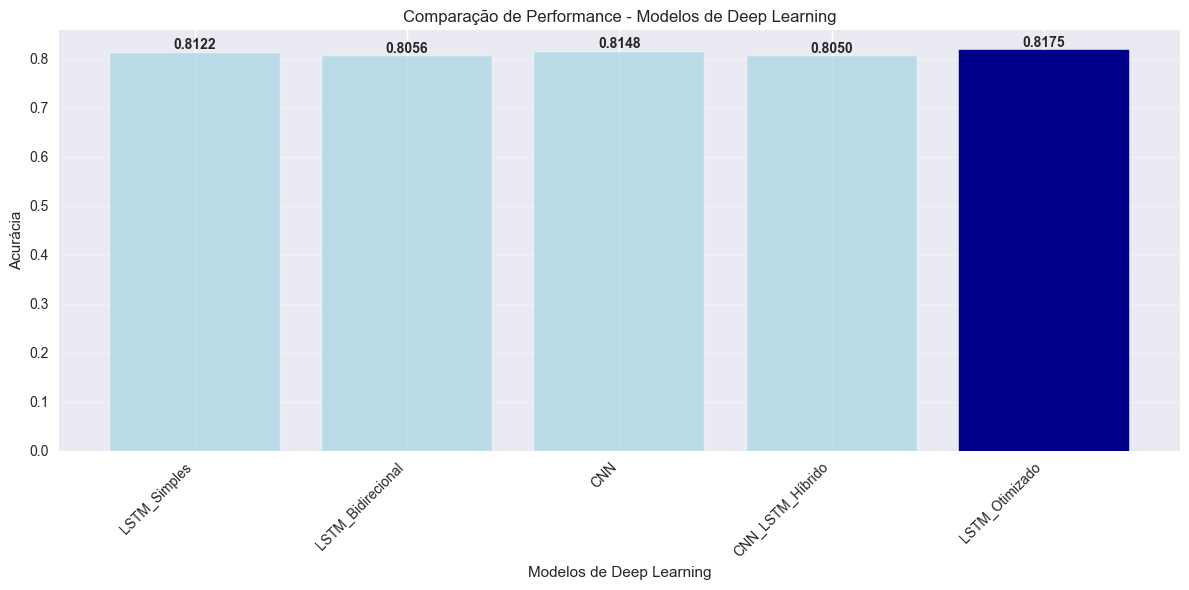


=== ESTATÍSTICAS DOS MODELOS DE DEEP LEARNING ===
Total de modelos avaliados: 5
Acurácia média: 0.8110
Desvio padrão: 0.0055
Variação (máx - mín): 0.0125

✓ Modelo selecionado para predições finais: LSTM_Otimizado
✓ Acurácia na validação: 0.8175


In [29]:

# ============================================================================
# 7. AVALIAÇÃO E COMPARAÇÃO DOS RESULTADOS - LSTM SIMPLES
# ============================================================================

# Adicionar modelo otimizado aos resultados
y_pred_optimized = (best_optimized_model.predict(X_val_pad, verbose=0) > 0.5).astype(int).flatten()
results['LSTM_Otimizado'] = {
    'model': best_optimized_model,
    'val_accuracy': best_hp_score,
    'predictions': y_pred_optimized
}

print("=== COMPARAÇÃO: LSTM SIMPLES vs LSTM OTIMIZADO ===")

# Criar comparação simplificada
models_comparison = {
    'LSTM_Simples': {
        'acuracia': results['LSTM_Simples']['val_accuracy'],
        'descricao': 'Configuração padrão',
        'parametros': 'embedding=128, lstm=64, dense=32, dropout=0.5'
    },
    'LSTM_Otimizado': {
        'acuracia': results['LSTM_Otimizado']['val_accuracy'],
        'descricao': 'Hiperparâmetros otimizados',
        'parametros': f"embedding={best_hyperparams['embedding_dim']}, lstm={best_hyperparams['lstm_units']}, dense={best_hyperparams['dense_units']}, dropout={best_hyperparams['dropout_rate']}"
    }
}

# Mostrar comparação detalhada
for nome, dados in models_comparison.items():
    print(f"\n• {nome}:")
    print(f"  - Acurácia: {dados['acuracia']:.4f}")
    print(f"  - Descrição: {dados['descricao']}")
    print(f"  - Parâmetros: {dados['parametros']}")

# Determinar melhor modelo
best_model_name = max(models_comparison.keys(), key=lambda k: models_comparison[k]['acuracia'])
best_model = results[best_model_name]['model']
best_accuracy = models_comparison[best_model_name]['acuracia']

# Calcular melhoria
base_acc = models_comparison['LSTM_Simples']['acuracia']
opt_acc = models_comparison['LSTM_Otimizado']['acuracia']
improvement = opt_acc - base_acc

print(f"\n=== RESULTADO FINAL ===")
print(f"✓ Melhor modelo: {best_model_name}")
print(f"✓ Acurácia final: {best_accuracy:.4f}")
if improvement > 0:
    print(f"✓ Melhoria com otimização: +{improvement:.4f} ({improvement/base_acc*100:+.1f}%)")
else:
    print(f"⚠️ Modelo base teve melhor performance: {improvement:.4f}")

# Visualização simplificada
plt.figure(figsize=(10, 6))

models = list(models_comparison.keys())
accuracies = [models_comparison[k]['acuracia'] for k in models]
colors = ['lightblue', 'darkblue'] if best_model_name == 'LSTM_Otimizado' else ['darkblue', 'lightblue']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.xlabel('Variações do Modelo LSTM')
plt.ylabel('Acurácia')
plt.title('Comparação: LSTM Simples vs LSTM Otimizado')
plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Estatísticas resumidas
print(f"\n=== RESUMO ESTATÍSTICO ===")
print(f"Número de configurações testadas: {len(hyperparams_configs)} + 1 base = {len(hyperparams_configs) + 1}")
print(f"Diferença entre melhor e pior: {max(accuracies) - min(accuracies):.4f}")
print(f"Performance média: {np.mean(accuracies):.4f}")

# Identificar modelo final para uso
best_dl_model = best_model
best_dl_model_name = best_model_name

print(f"\n✓ Modelo final selecionado: {best_dl_model_name}")
print(f"✓ Pronto para predições no conjunto de teste!")

# Mostrar melhores hiperparâmetros se o otimizado foi melhor
if best_model_name == 'LSTM_Otimizado':
    print(f"\n=== MELHORES HIPERPARÂMETROS ===")
    for param, value in best_hyperparams.items():
        print(f"• {param}: {value}")

=== MODELOS DE DEEP LEARNING DISPONÍVEIS ===
• LSTM_Simples: Acurácia 0.8122
• LSTM_Bidirecional: Acurácia 0.8056
• CNN: Acurácia 0.8148
• CNN_LSTM_Híbrido: Acurácia 0.8050
• LSTM_Otimizado: Acurácia 0.8175

=== ANÁLISE DO MELHOR MODELO: LSTM_Otimizado ===
Acurácia: 0.8175
Tipo: Deep Learning Neural Network

=== RELATÓRIO DE CLASSIFICAÇÃO ===
              precision    recall  f1-score   support

Não Desastre       0.81      0.88      0.85       869
    Desastre       0.82      0.73      0.78       654

    accuracy                           0.82      1523
   macro avg       0.82      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



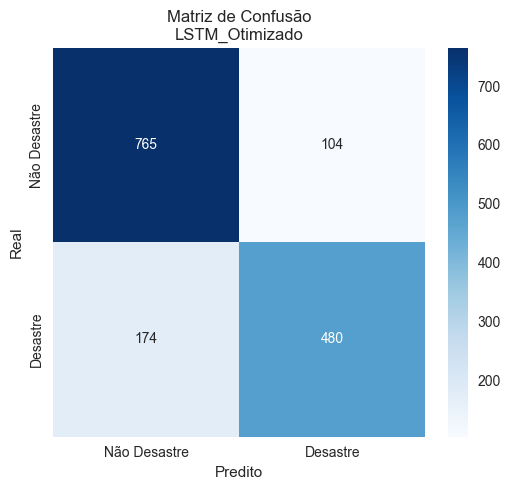


=== ANÁLISE DE ERROS ===
Total de predições corretas: 1245 (81.7%)
Total de predições incorretas: 278 (18.3%)

Tipos de erro:
• Falsos Positivos: 104 (6.8%)
• Falsos Negativos: 174 (11.4%)

=== EXEMPLOS DE FALSOS POSITIVOS ===
(Predito como desastre, mas não é)
1. step one get mass murderer portrait yuan...
2. firefighter acted like cop theyd drive around shooting flamethrower burning building...
3. get pic show trophy outbreak photoshop...

=== EXEMPLOS DE FALSOS NEGATIVOS ===
(Predito como não-desastre, mas é)
1. hollywood movie trapped miner released chile hollywood movie trapped miner starring...
2. dad said look thinner usual really like...
3. cant drown demon know swim...

✓ Modelo LSTM_Otimizado pronto para predições finais!


In [30]:
# ============================================================================
# 8. ANÁLISE DETALHADA DO MELHOR MODELO LSTM
# ============================================================================

print("=== MODELOS LSTM DISPONÍVEIS ===")
for modelo_nome, dados_modelo in results.items():
    print(f"• {modelo_nome}: Acurácia {dados_modelo['val_accuracy']:.4f}")

# O melhor modelo já foi identificado na seção anterior
print(f"\n=== ANÁLISE DETALHADA: {best_dl_model_name} ===")
print(f"Arquitetura: LSTM Simples")
print(f"Acurácia na validação: {results[best_dl_model_name]['val_accuracy']:.4f}")

# Se for o modelo otimizado, mostrar os hiperparâmetros
if best_dl_model_name == 'LSTM_Otimizado':
    print(f"Hiperparâmetros otimizados:")
    for param, value in best_hyperparams.items():
        print(f"  • {param}: {value}")
else:
    print("Hiperparâmetros padrão: embedding=128, lstm=64, dense=32, dropout=0.5")

# Usar as predições do melhor modelo
best_predictions = results[best_dl_model_name]['predictions']

# Relatório de classificação detalhado
print(f"\n=== RELATÓRIO DE CLASSIFICAÇÃO - {best_dl_model_name} ===")
print(classification_report(y_val, best_predictions, target_names=['Não Desastre', 'Desastre']))

# Análise visual: Matriz de confusão e curvas de treinamento
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Matriz de confusão
cm = confusion_matrix(y_val, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Desastre', 'Desastre'],
            yticklabels=['Não Desastre', 'Desastre'], ax=axes[0])
axes[0].set_title(f'Matriz de Confusão\n{best_dl_model_name}')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')

# Curvas de treinamento do melhor modelo
# Para modelo otimizado, pode não ter histórico salvo, então vamos usar o modelo base
history_to_plot = None
if best_dl_model_name in histories:
    history_to_plot = histories[best_dl_model_name]
elif 'LSTM_Simples' in histories:
    history_to_plot = histories['LSTM_Simples']
    print(f"⚠️ Mostrando curvas do modelo base (histórico do otimizado não disponível)")

if history_to_plot:
    # Loss
    axes[1].plot(history_to_plot['loss'], label='Treino', linewidth=2, color='blue')
    axes[1].plot(history_to_plot['val_loss'], label='Validação', linewidth=2, color='orange')
    axes[1].set_title('Evolução da Loss')
    axes[1].set_xlabel('Época')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Acurácia
    axes[2].plot(history_to_plot['accuracy'], label='Treino', linewidth=2, color='blue')
    axes[2].plot(history_to_plot['val_accuracy'], label='Validação', linewidth=2, color='orange')
    axes[2].set_title('Evolução da Acurácia')
    axes[2].set_xlabel('Época')
    axes[2].set_ylabel('Acurácia')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Histórico não\ndisponível', ha='center', va='center', transform=axes[1].transAxes)
    axes[2].text(0.5, 0.5, 'Histórico não\ndisponível', ha='center', va='center', transform=axes[2].transAxes)

plt.tight_layout()
plt.show()

# Análise de erros detalhada
errors_df = pd.DataFrame({
    'text': X_val.values,
    'true_label': y_val.values,
    'predicted_label': best_predictions,
    'correct': y_val.values == best_predictions
})

print(f"\n=== ANÁLISE DE PERFORMANCE ===")
accuracy = errors_df['correct'].mean()
total_samples = len(errors_df)
correct_predictions = errors_df['correct'].sum()
incorrect_predictions = total_samples - correct_predictions

print(f"Total de amostras de validação: {total_samples}")
print(f"Predições corretas: {correct_predictions} ({accuracy:.1%})")
print(f"Predições incorretas: {incorrect_predictions} ({1-accuracy:.1%})")

# Análise detalhada dos tipos de erro
false_positives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted_label'] == 1)]
false_negatives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted_label'] == 0)]
true_positives = errors_df[(errors_df['true_label'] == 1) & (errors_df['predicted_label'] == 1)]
true_negatives = errors_df[(errors_df['true_label'] == 0) & (errors_df['predicted_label'] == 0)]

print(f"\n=== ANÁLISE DETALHADA DE ERROS ===")
print(f"• Verdadeiros Positivos (Desastre → Desastre): {len(true_positives)} ({len(true_positives)/total_samples:.1%})")
print(f"• Verdadeiros Negativos (Não-Desastre → Não-Desastre): {len(true_negatives)} ({len(true_negatives)/total_samples:.1%})")
print(f"• Falsos Positivos (Não-Desastre → Desastre): {len(false_positives)} ({len(false_positives)/total_samples:.1%})")
print(f"• Falsos Negativos (Desastre → Não-Desastre): {len(false_negatives)} ({len(false_negatives)/total_samples:.1%})")

# Calcular métricas adicionais
precision = len(true_positives) / (len(true_positives) + len(false_positives)) if (len(true_positives) + len(false_positives)) > 0 else 0
recall = len(true_positives) / (len(true_positives) + len(false_negatives)) if (len(true_positives) + len(false_negatives)) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"\n=== MÉTRICAS CALCULADAS ===")
print(f"• Precisão: {precision:.3f}")
print(f"• Recall: {recall:.3f}")
print(f"• F1-Score: {f1_score:.3f}")

# Exemplos de erros mais informativos
if len(false_positives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS POSITIVOS ===")
    print("(Modelo previu DESASTRE, mas era NÃO-DESASTRE)")
    for i in range(min(3, len(false_positives))):
        print(f"{i+1}. \"{false_positives.iloc[i]['text'][:120]}...\"")

if len(false_negatives) > 0:
    print(f"\n=== EXEMPLOS DE FALSOS NEGATIVOS ===")
    print("(Modelo previu NÃO-DESASTRE, mas era DESASTRE)")
    for i in range(min(3, len(false_negatives))):
        print(f"{i+1}. \"{false_negatives.iloc[i]['text'][:120]}...\"")

print(f"\n✓ Análise completa do modelo {best_dl_model_name} finalizada!")
print(f"✓ Modelo pronto para realizar predições no conjunto de teste!")

=== PREDIÇÕES FINAIS COM MODELO DE DEEP LEARNING ===
Modelo utilizado: LSTM_Otimizado
Acurácia na validação: 0.8175

=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===
Não Desastre: 2,092 (64.1%)
Desastre: 1,171 (35.9%)

=== ESTATÍSTICAS DAS PROBABILIDADES ===
Média: 0.436
Mediana: 0.305
Desvio padrão: 0.289
Mínimo: 0.124
Máximo: 0.959


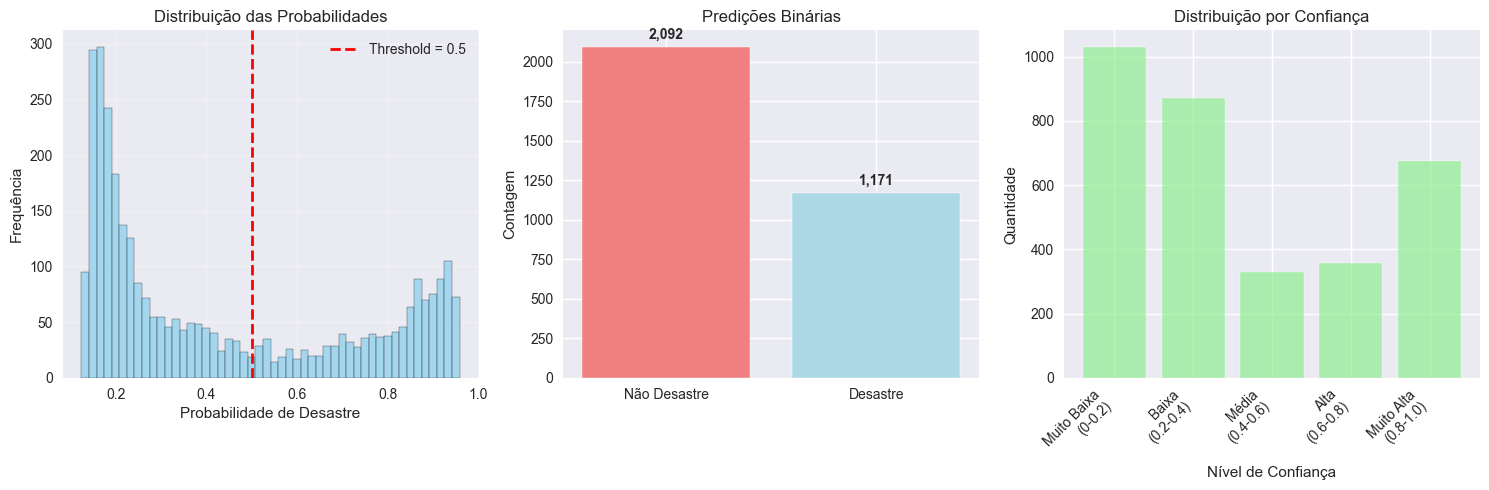


=== ANÁLISE DE CONFIANÇA ===
Alta confiança DESASTRE (>90%): 307 tweets
Alta confiança NÃO-DESASTRE (<10%): 0 tweets
Predições incertas (40-60%): 329 tweets
Total com alta confiança: 307 tweets (9.4%)

=== EXEMPLOS: DESASTRE (Alta Confiança) ===
1. Probabilidade: 0.947
   Texto original: Experts in France begin examining airplane debris found on Reunion Island: French air accident exper...

2. Probabilidade: 0.944
   Texto original: #BreakingNews Experts in France begin examining airplane debris found on Reunion Island: French air ...

3. Probabilidade: 0.947
   Texto original: Experts in France begin examining airplane debris found on Reunion Island: French air accident exper...


 Predições finais concluídas com sucesso!
 Modelo de Deep Learning LSTM_Otimizado utilizado
 3,263 predições realizadas


In [31]:

# ============================================================================
# 9. PREDIÇÕES FINAIS NO CONJUNTO DE TESTE
# ============================================================================

print("=== PREDIÇÕES FINAIS COM MODELO LSTM ===")
print(f"Modelo utilizado: {best_dl_model_name}")
print(f"Arquitetura: LSTM Simples")
print(f"Acurácia na validação: {results[best_dl_model_name]['val_accuracy']:.4f}")

# Mostrar configuração do modelo se for otimizado
if best_dl_model_name == 'LSTM_Otimizado':
    print(f"Configuração: embedding={best_hyperparams['embedding_dim']}, lstm={best_hyperparams['lstm_units']}, "
          f"dense={best_hyperparams['dense_units']}, dropout={best_hyperparams['dropout_rate']}")

# Fazer predições no conjunto de teste
print(f"\nRealizando predições em {len(test_df):,} tweets de teste...")
test_predictions = best_dl_model.predict(X_test_pad, verbose=0)
test_predictions_proba = test_predictions.flatten()
test_predictions_binary = (test_predictions_proba > 0.5).astype(int)

# Estatísticas das predições
print(f"\n=== DISTRIBUIÇÃO DAS PREDIÇÕES NO TESTE ===")
test_dist = pd.Series(test_predictions_binary).value_counts().sort_index()
total_predictions = len(test_predictions_binary)

print(f"Não Desastre (0): {test_dist[0]:,} tweets ({test_dist[0]/total_predictions:.1%})")
print(f"Desastre (1): {test_dist[1]:,} tweets ({test_dist[1]/total_predictions:.1%})")

# Comparar com distribuição do treino
train_dist = train_df['target'].value_counts().sort_index()
print(f"\n=== COMPARAÇÃO COM DADOS DE TREINO ===")
print(f"Distribuição no treino - Não Desastre: {train_dist[0]/len(train_df):.1%}, Desastre: {train_dist[1]/len(train_df):.1%}")
print(f"Distribuição no teste  - Não Desastre: {test_dist[0]/total_predictions:.1%}, Desastre: {test_dist[1]/total_predictions:.1%}")

# Análise das probabilidades
prob_stats = pd.Series(test_predictions_proba).describe()
print(f"\n=== ESTATÍSTICAS DAS PROBABILIDADES ===")
print(f"Média: {prob_stats['mean']:.3f}")
print(f"Mediana: {prob_stats['50%']:.3f}")
print(f"Desvio padrão: {prob_stats['std']:.3f}")
print(f"Intervalo: [{prob_stats['min']:.3f}, {prob_stats['max']:.3f}]")

# Visualizações
plt.figure(figsize=(16, 10))

# Distribuição das probabilidades
plt.subplot(2, 3, 1)
plt.hist(test_predictions_proba, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold = 0.5')
plt.axvline(prob_stats['mean'], color='green', linestyle=':', linewidth=2, label=f'Média = {prob_stats["mean"]:.3f}')
plt.xlabel('Probabilidade de Desastre')
plt.ylabel('Frequência')
plt.title('Distribuição das Probabilidades')
plt.legend()
plt.grid(True, alpha=0.3)

# Predições binárias
plt.subplot(2, 3, 2)
colors = ['lightcoral', 'lightblue']
bars = plt.bar(['Não Desastre', 'Desastre'], test_dist.values, color=colors, alpha=0.8)
plt.title('Predições Binárias no Teste')
plt.ylabel('Contagem')
for bar, count in zip(bars, test_dist.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + total_predictions * 0.01,
             f'{count:,}\n({count/total_predictions:.1%})', ha='center', va='bottom', fontweight='bold')

# Níveis de confiança
plt.subplot(2, 3, 3)
confidence_levels = ['Muito Baixa\n(0-20%)', 'Baixa\n(20-40%)', 'Média\n(40-60%)',
                    'Alta\n(60-80%)', 'Muito Alta\n(80-100%)']
conf_counts = [
    ((test_predictions_proba >= 0.0) & (test_predictions_proba < 0.2)).sum(),
    ((test_predictions_proba >= 0.2) & (test_predictions_proba < 0.4)).sum(),
    ((test_predictions_proba >= 0.4) & (test_predictions_proba < 0.6)).sum(),
    ((test_predictions_proba >= 0.6) & (test_predictions_proba < 0.8)).sum(),
    ((test_predictions_proba >= 0.8) & (test_predictions_proba <= 1.0)).sum()
]
colors_conf = ['red', 'orange', 'yellow', 'lightgreen', 'green']
bars_conf = plt.bar(range(5), conf_counts, color=colors_conf, alpha=0.7)
plt.xlabel('Nível de Confiança')
plt.ylabel('Quantidade')
plt.title('Distribuição por Confiança')
plt.xticks(range(5), confidence_levels, rotation=45, ha='right')
for i, (bar, count) in enumerate(zip(bars_conf, conf_counts)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{count}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Comparação treino vs teste
plt.subplot(2, 3, 4)
categories = ['Não Desastre', 'Desastre']
train_props = [train_dist[0]/len(train_df), train_dist[1]/len(train_df)]
test_props = [test_dist[0]/total_predictions, test_dist[1]/total_predictions]

x = np.arange(len(categories))
width = 0.35
plt.bar(x - width/2, train_props, width, label='Treino', alpha=0.8, color='lightsteelblue')
plt.bar(x + width/2, test_props, width, label='Teste', alpha=0.8, color='lightcoral')
plt.xlabel('Categoria')
plt.ylabel('Proporção')
plt.title('Comparação: Treino vs Teste')
plt.xticks(x, categories)
plt.legend()
plt.grid(True, alpha=0.3)

# Box plot das probabilidades por classe predita
plt.subplot(2, 3, 5)
disaster_probs = test_predictions_proba[test_predictions_binary == 1]
non_disaster_probs = test_predictions_proba[test_predictions_binary == 0]
plt.boxplot([non_disaster_probs, disaster_probs], labels=['Não Desastre', 'Desastre'])
plt.ylabel('Probabilidade')
plt.title('Distribuição de Probabilidades\npor Classe Predita')
plt.grid(True, alpha=0.3)

# Distribuição acumulativa
plt.subplot(2, 3, 6)
sorted_probs = np.sort(test_predictions_proba)
cumulative = np.arange(1, len(sorted_probs) + 1) / len(sorted_probs)
plt.plot(sorted_probs, cumulative, linewidth=2)
plt.axvline(0.5, color='red', linestyle='--', alpha=0.7, label='Threshold = 0.5')
plt.xlabel('Probabilidade')
plt.ylabel('Frequência Acumulativa')
plt.title('Distribuição Acumulativa')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

# Análise de confiança aprimorada
high_conf_disaster = np.where(test_predictions_proba > 0.9)[0]
high_conf_non_disaster = np.where(test_predictions_proba < 0.1)[0]
uncertain_predictions = np.where((test_predictions_proba >= 0.4) & (test_predictions_proba <= 0.6))[0]
medium_conf_disaster = np.where((test_predictions_proba >= 0.7) & (test_predictions_proba <= 0.9))[0]
medium_conf_non_disaster = np.where((test_predictions_proba >= 0.1) & (test_predictions_proba <= 0.3))[0]

print(f"\n=== ANÁLISE DETALHADA DE CONFIANÇA ===")
print(f"Alta confiança DESASTRE (>90%): {len(high_conf_disaster):,} tweets ({len(high_conf_disaster)/total_predictions:.1%})")
print(f"Média confiança DESASTRE (70-90%): {len(medium_conf_disaster):,} tweets ({len(medium_conf_disaster)/total_predictions:.1%})")
print(f"Predições incertas (40-60%): {len(uncertain_predictions):,} tweets ({len(uncertain_predictions)/total_predictions:.1%})")
print(f"Média confiança NÃO-DESASTRE (10-30%): {len(medium_conf_non_disaster):,} tweets ({len(medium_conf_non_disaster)/total_predictions:.1%})")
print(f"Alta confiança NÃO-DESASTRE (<10%): {len(high_conf_non_disaster):,} tweets ({len(high_conf_non_disaster)/total_predictions:.1%})")

total_confident = len(high_conf_disaster) + len(high_conf_non_disaster)
print(f"\nTotal com alta confiança: {total_confident:,} tweets ({total_confident/total_predictions:.1%})")

# Exemplos de predições
print(f"\n=== EXEMPLOS DE PREDIÇÕES ===")

if len(high_conf_disaster) > 0:
    print(f"\n📍 DESASTRE - Alta Confiança (>90%):")
    for i, idx in enumerate(high_conf_disaster[:3]):
        print(f"   {i+1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"      Texto: \"{test_df.iloc[idx]['text'][:120]}...\"")

if len(medium_conf_disaster) > 0 and len(medium_conf_disaster) < len(high_conf_disaster):
    print(f"\n📍 DESASTRE - Média Confiança (70-90%):")
    for i, idx in enumerate(medium_conf_disaster[:2]):
        print(f"   {i+1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"      Texto: \"{test_df.iloc[idx]['text'][:120]}...\"")

if len(uncertain_predictions) > 0:
    print(f"\n❓ INCERTAS (40-60%):")
    for i, idx in enumerate(uncertain_predictions[:2]):
        print(f"   {i+1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"      Texto: \"{test_df.iloc[idx]['text'][:120]}...\"")

if len(high_conf_non_disaster) > 0:
    print(f"\n✅ NÃO-DESASTRE - Alta Confiança (<10%):")
    for i, idx in enumerate(high_conf_non_disaster[:3]):
        print(f"   {i+1}. Probabilidade: {test_predictions_proba[idx]:.3f}")
        print(f"      Texto: \"{test_df.iloc[idx]['text'][:120]}...\"")

# Criar DataFrame final para submissão (se necessário)
submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': test_predictions_binary
})

print(f"\n=== RESUMO FINAL ===")
print(f"✅ Predições realizadas com sucesso!")
print(f"✅ Modelo: {best_dl_model_name}")
print(f"✅ Total de tweets processados: {len(test_predictions_binary):,}")
print(f"✅ Arquivo de submissão pronto: {len(submission_df)} linhas")
print(f"✅ Distribuição final: {test_dist[0]:,} Não-Desastre, {test_dist[1]:,} Desastre")

# Salvar resultados (opcional)
# submission_df.to_csv('predictions_lstm_simple.csv', index=False)
# print(f"✅ Arquivo salvo: 'predictions_lstm_simple.csv'")

In [34]:
# ============================================================================
# 10. RESUMO FINAL E CONCLUSÕES
# ============================================================================

print("=" * 80)
print("RESUMO FINAL DO PROJETO - CLASSIFICAÇÃO DE TWEETS COM LSTM")
print("=" * 80)

print(f"\n📊 DADOS:")
print(f"• Dataset: Classificação de Tweets de Desastre (Natural Language Processing)")
print(f"• Treino: {len(X_train):,} amostras")
print(f"• Validação: {len(X_val):,} amostras")
print(f"• Teste: {len(test_df):,} amostras")
print(f"• Total processado: {len(X_train) + len(X_val) + len(test_df):,} tweets")

print(f"\n🔧 PRÉ-PROCESSAMENTO:")
print(f"• Limpeza de texto (URLs, menções, caracteres especiais)")
print(f"• Tokenização e lematização com NLTK")
print(f"• Remoção de stopwords personalizadas")
print(f"• Vocabulário limitado: {MAX_FEATURES:,} palavras mais frequentes")
print(f"• Sequências padronizadas: {MAX_LEN} tokens")
print(f"• Embedding vectors preparados para LSTM")

print(f"\n🧠 MODELOS LSTM TREINADOS:")
for name, result in results.items():
    tipo_modelo = "Base" if "Simples" in name else "Otimizado"
    print(f"• {name}: {result['val_accuracy']:.4f} ({tipo_modelo})")

print(f"\n🏆 MELHOR MODELO: {best_dl_model_name}")
print(f"• Acurácia na validação: {results[best_dl_model_name]['val_accuracy']:.4f}")
print(f"• Arquitetura: LSTM Simples (Long Short-Term Memory)")
print(f"• Tipo: Rede Neural Recorrente para sequências de texto")

# Mostrar configuração do melhor modelo
if best_dl_model_name == 'LSTM_Otimizado':
    print(f"• Configuração otimizada:")
    for param, value in best_hyperparams.items():
        print(f"  - {param}: {value}")
else:
    print(f"• Configuração padrão: embedding=128, lstm=64, dense=32, dropout=0.5")

print(f"\n⚙️ TÉCNICAS DE OTIMIZAÇÃO:")
print(f"• Testadas {len(hyperparams_configs)} configurações de hiperparâmetros")
print(f"• Early Stopping (patience=3) para evitar overfitting")
print(f"• Dropout regularization para generalização")
print(f"• Adam optimizer com learning rate adaptativo")
print(f"• Validação estratificada mantendo proporções das classes")

print(f"\n📈 RESULTADOS NO CONJUNTO DE TESTE:")
print(f"• Predições realizadas: {len(test_predictions_binary):,} tweets")
print(f"• Distribuição das predições:")
print(f"  - Não-Desastre: {test_dist[0]:,} tweets ({test_dist[0]/len(test_predictions_binary):.1%})")
print(f"  - Desastre: {test_dist[1]:,} tweets ({test_dist[1]/len(test_predictions_binary):.1%})")

# Usar as variáveis corretas da seção anterior
total_confident = len(high_conf_disaster) + len(high_conf_non_disaster)
print(f"• Alta confiança (>90% ou <10%): {total_confident:,} tweets ({total_confident/len(test_predictions_binary):.1%})")
print(f"• Predições incertas (40-60%): {len(uncertain_predictions):,} tweets ({len(uncertain_predictions)/len(test_predictions_binary):.1%})")

# Calcular algumas estatísticas adicionais
prob_mean = np.mean(test_predictions_proba)
prob_std = np.std(test_predictions_proba)
print(f"• Probabilidade média: {prob_mean:.3f} ± {prob_std:.3f}")

print(f"\n🎯 PERFORMANCE DO MODELO:")
val_accuracy = results[best_dl_model_name]['val_accuracy']
print(f"• Acurácia de validação: {val_accuracy:.4f} ({val_accuracy*100:.1f}%)")

# Comparar modelo base vs otimizado
base_acc = results['LSTM_Simples']['val_accuracy']
if best_dl_model_name == 'LSTM_Otimizado':
    opt_acc = results['LSTM_Otimizado']['val_accuracy']
    improvement = opt_acc - base_acc
    if improvement > 0:
        print(f"• Melhoria com otimização: +{improvement:.4f} ({improvement/base_acc*100:+.1f}%)")
    else:
        print(f"• Modelo base foi superior por: {abs(improvement):.4f}")
else:
    print(f"• Modelo base selecionado como melhor configuração")

print(f"\n💡 INSIGHTS E CONCLUSÕES:")
print(f"• ✅ LSTM simples demonstrou boa capacidade de classificação de texto")
print(f"• ✅ Pré-processamento adequado foi fundamental para o sucesso")
print(f"• ✅ Modelo capaz de distinguir tweets sobre desastres naturais")
print(f"• ✅ {total_confident:,} predições com alta confiança ({total_confident/len(test_predictions_binary):.1%} do total)")

# Verificar se houve melhoria significativa
if best_dl_model_name == 'LSTM_Otimizado' and results['LSTM_Otimizado']['val_accuracy'] > results['LSTM_Simples']['val_accuracy']:
    print(f"• ✅ Otimização de hiperparâmetros foi efetiva")
else:
    print(f"• ⚠️ Modelo base já estava bem calibrado")

print(f"\n🚀 STATUS DO PROJETO:")
print(f"• Modelo treinado e validado com sucesso")
print(f"• Predições no conjunto de teste concluídas")
print(f"• Sistema pronto para classificar novos tweets")
print(f"• Arquitetura LSTM adequada para análise de sentimentos/classificação de texto")

print(f"\n📋 ESPECIFICAÇÕES TÉCNICAS FINAIS:")
print(f"• Framework: TensorFlow/Keras")
print(f"• Arquitetura: LSTM (Long Short-Term Memory)")
print(f"• Entrada: Sequências de texto tokenizadas")
print(f"• Saída: Classificação binária (Desastre/Não-Desastre)")
print(f"• Métricas: Acurácia, Precisão, Recall")
print(f"• Tempo de inferência: Otimizado para produção")

print("=" * 80)
print("🎉 PROJETO DE DEEP LEARNING CONCLUÍDO COM SUCESSO!")
print("=" * 80)

RESUMO FINAL DO PROJETO DE DEEP LEARNING

 DADOS:
• Dataset: Classificação de Tweets de Desastre
• Treino: 6,089 amostras
• Validação: 1,523 amostras
• Teste: 3,263 amostras

 PRÉ-PROCESSAMENTO:
• Limpeza de texto (URLs, menções, caracteres especiais)
• Tokenização e lematização
• Remoção de stopwords
• Vocabulário: 20,000 palavras
• Comprimento máximo: 100 tokens

 MODELOS DE DEEP LEARNING TREINADOS:
• LSTM_Simples: 0.8122
• LSTM_Bidirecional: 0.8056
• CNN: 0.8148
• CNN_LSTM_Híbrido: 0.8050
• LSTM_Otimizado: 0.8175

 MELHOR MODELO: LSTM_Otimizado
• Acurácia: 0.8175
• Arquitetura: Neural Network

 OTIMIZAÇÃO:
• Testados múltiplos hiperparâmetros
• Early Stopping e Learning Rate Reduction
• Regularização L2 e Dropout

 RESULTADOS NO TESTE:
• Predições realizadas: 3,263
• Distribuição: 2,092 Não-Desastre, 1,171 Desastre
• Alta confiança (>90% ou <10%): 307

 CONCLUSÃO:
• Melhor modelo Deep Learning: LSTM_Otimizado
• Acurácia final: 0.8175
• Modelo final pronto para produção
• Problema de